# Third Experiment

Driver:

    - cores: 1
    - coreLimit: "1200m"
    - memory: "2g"

Executor:

    - cores: 2
    - instances: 2
    - memory: "4g"

Just created 1 executor in each cluster for resource limitations.

`"max.in.flight.requests.per.connection": 5`

Start 15:35 27-04-2025

Stop 16:05 27-04-2025

In [1]:
import pandas as pd
import sys
from pathlib import Path

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

from functions import calculate_latencies
from utils import fix_timestamps_timezone
from charts import latency_box_plot, latency_line_plot, latency_distribution_plot

experiment_name = "third_experiment"

df_cloud = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-04-27-16_16_09-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("source_timestamp")
df_edge = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-04-27-16_22_05-avro-edge.parquet")
df_edge = df_edge.sort_values("source_timestamp")

In [2]:
df_cloud = fix_timestamps_timezone(df_cloud)
df_edge = fix_timestamps_timezone(df_edge)

In [3]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

In [4]:
start_time = pd.Timestamp("2025-04-27 15:35:00", tz="UTC")
end_time = pd.Timestamp("2025-04-27 16:05:00", tz="UTC")

# 2. Filtrar ambos os dataframes para esse intervalo
df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= start_time) &
    (df_cloud["source_timestamp"] <= end_time)
]

df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= start_time) &
    (df_edge["source_timestamp"] <= end_time)
]

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1098: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


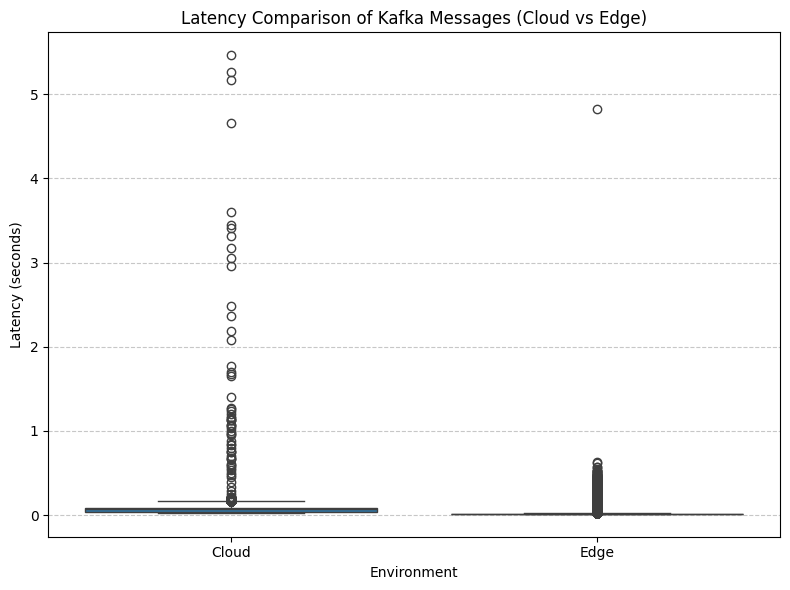

In [5]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="source_kafka_latency")

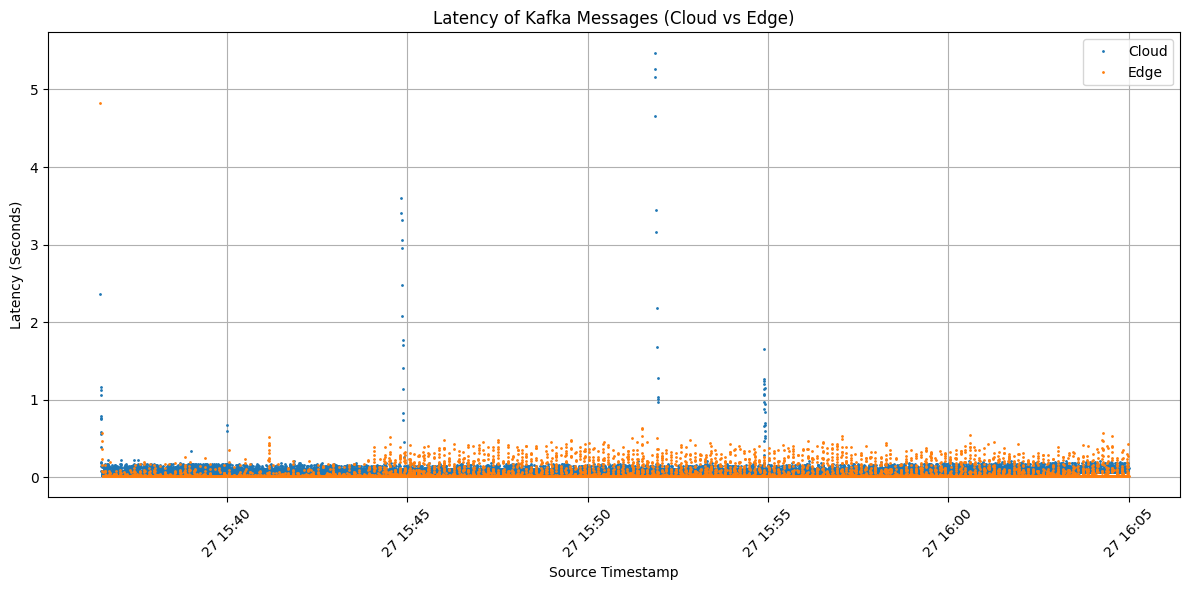

In [6]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x="source_timestamp", y="source_kafka_latency")

📊 Statistics:
                 mean    median       std
Environment                              
Cloud        0.076521  0.072721  0.122478
Edge         0.037330  0.017598  0.072562


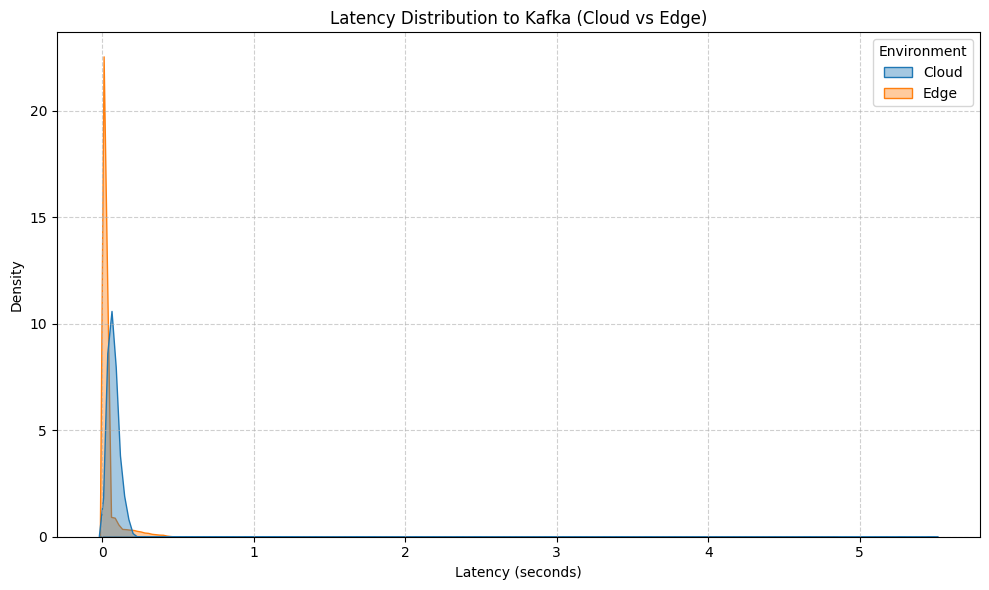

In [7]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="source_kafka_latency")

Big latencies probably generated by new producer configuration "max.in.flight.requests.per.connection": 5, which can cause message reordering since parallelism sends message without ack from the broker. Failed messages may be reaching the broker late. This prioritizes throughput but causes some message loss. A new test will return to "max.in.flight.requests.per.connection": 1, **but throughput must be measured.**

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1098: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


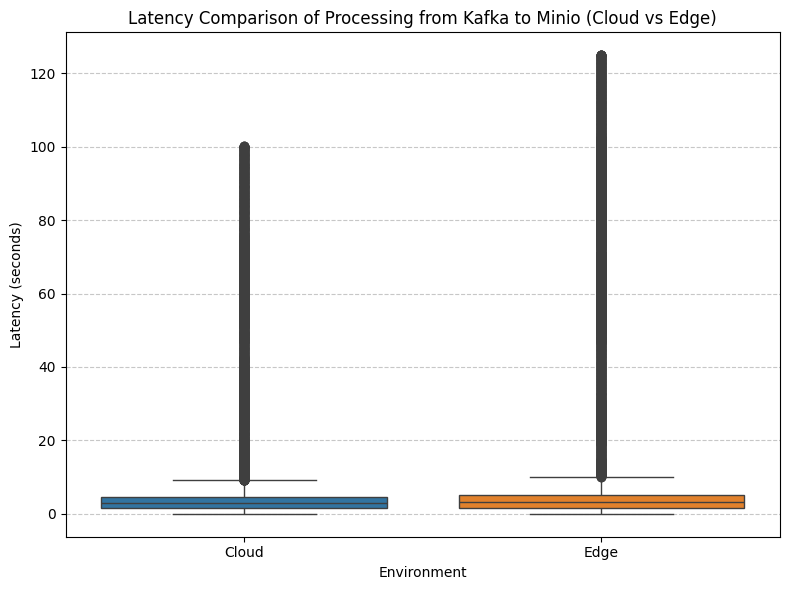

In [8]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="kafka_landing_latency", title="Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)")

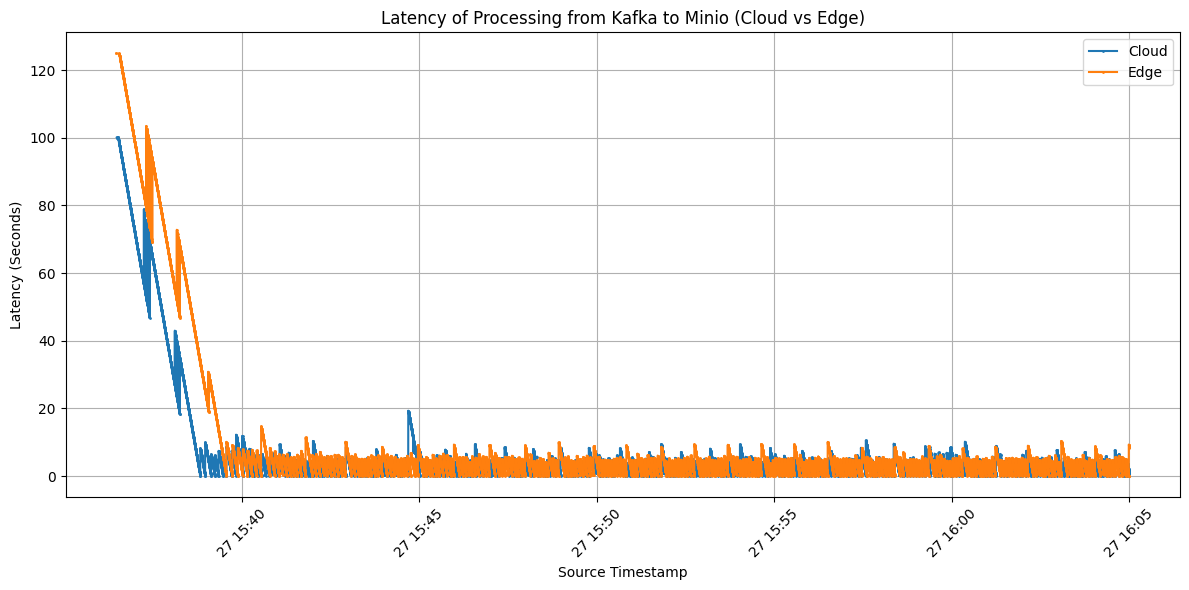

In [9]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x='source_timestamp', y='kafka_landing_latency', title='Latency of Processing from Kafka to Minio (Cloud vs Edge)', linestyle="solid")

For the data lake processing cloud performed better in average, but edge seems to have less standard deviation. 

📊 Statistics:
                 mean  median        std
Environment                             
Cloud        6.890074  2.9920  15.119737
Edge         9.579392  3.3195  21.564948


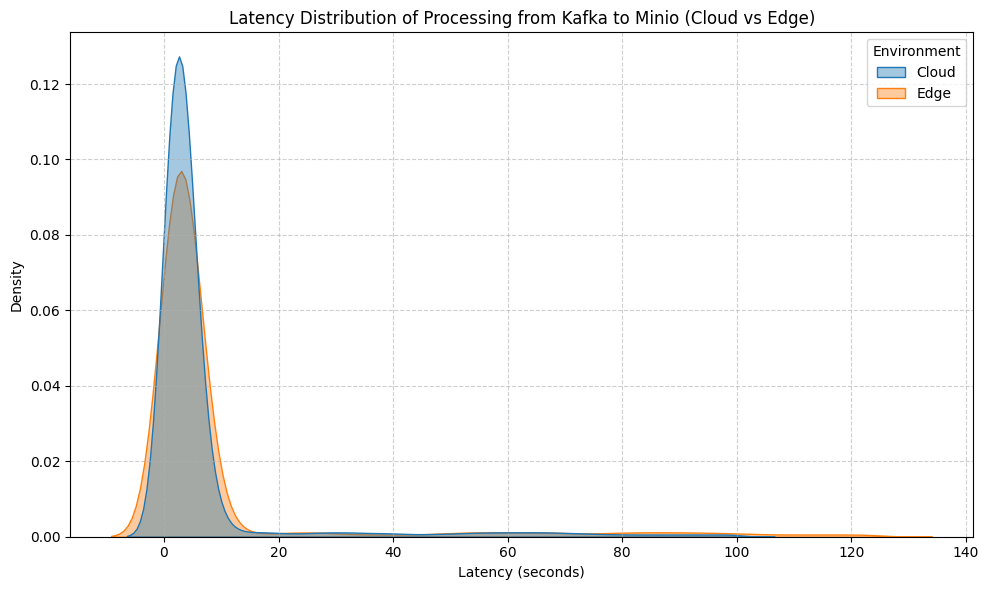

In [10]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="kafka_landing_latency", title="Latency Distribution of Processing from Kafka to Minio (Cloud vs Edge)")